In [1]:
train_path = "../images/training_set"
test_path = "../images/test_set"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [3]:
transform = transforms.Compose([transforms.Resize((324,324)),
                                      transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.0234, 0.0898, 0.1652],
                                                            [0.4543, 0.4443, 0.4453])])

#we caluculated the mean and std of the dataset mean=[0.0234, 0.0898, 0.1652] std=[0.4543, 0.4443, 0.4453]

In [4]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

In [5]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    # If dataset is a Subset, get the original dataset
    if isinstance(dataset, torch.utils.data.Subset):
        dataset_classes = dataset.dataset.classes
    else:
        dataset_classes = dataset.classes
    
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert from tensor to numpy for displaying
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {dataset_classes[label]}')
        axes[i].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


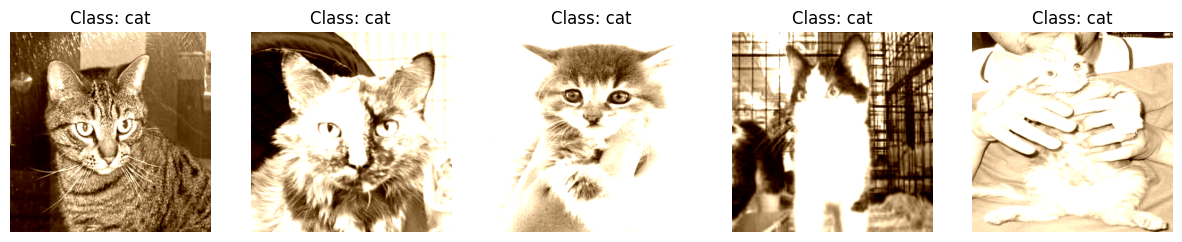

In [6]:
show_images(train_dataset, num_images=5)

In [ ]:
# #Compute the Mean and Standard Deviation of the Dataset


# # Initialize tensors to store sum and squared sum
# mean = 0.0
# std = 0.0
# n_samples = 0

# for images, _ in trainLoader:
#     # Flatten the batch of images into a single long vector for each channel
#     images = images.view(images.size(0), images.size(1), -1)  # shape (batch_size, channels, height*width)
    
#     # Sum and squared sum
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     n_samples += images.size(0)

# # Calculate the mean and std across the entire dataset
# mean /= n_samples
# std /= n_samples

# print(f"Calculated mean: {mean}")
# print(f"Calculated std: {std}")

In [7]:
train_size = int(0.8 * len(train_dataset))

val_size = len(train_dataset) - train_size

In [8]:
train_dataset , valid_dataset = random_split(train_dataset,[train_size,val_size])

In [9]:
batch_size = 32

In [10]:
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validLoader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
print(train_dataset.dataset.classes)

In [12]:

# con_output_size = ((w-f+2p)/s)+1
# pol_output_size = x / stride   with:(w*x*x size of input) 

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,3,padding=1)
        self.conv2 = nn.Conv2d(10,20,3,padding=1)
        self.conv3 = nn.Conv2d(20,40,3,padding=1)
        self.conv4 = nn.Conv2d(40,80,3,padding=1)

        self.pool = nn.MaxPool2d(3,3)

        self.fc1 = nn.Linear(80 * 4 * 4,2000)
        self.fc2 = nn.Linear(2000,600)
        self.fc3 = nn.Linear(600,2)

        self.dropout = nn.Dropout2d(0.25)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1,80 * 4 * 4)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))

        return x

In [ ]:
torch.cuda.is_available()

In [13]:
classes = ['cat', 'dog']

In [14]:
model = ConvNet().to("cuda")

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs = 60
train_accuracies = []
valid_accuracies = []
valid_loss_min = np.Inf

In [ ]:
for epoch in range(epochs):
    model.train()

    trainning_loss = 0
    valid_loss = 0
    correct_train = 0
    correct_valid = 0
    total_train = 0
    total_valid = 0

    # Training phase
    for images, labels in trainLoader:
        images, labels = images.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        trainning_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Validation phase
    with torch.no_grad():
        model.eval()

        for images, labels in validLoader:
            images, labels = images.to("cuda"), labels.to("cuda")

            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

    # Calculate average losses
    total_train_loss = trainning_loss / len(trainLoader)
    total_valid_loss = valid_loss / len(validLoader)

    # Calculate accuracy
    train_accuracy = correct_train / total_train
    valid_accuracy = correct_valid / total_valid

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch: {epoch+1} \tTraining Loss: {total_train_loss:.6f} \tValidation Loss: {total_valid_loss:.6f} \tTraining Accuracy: {train_accuracy:.2f} \tValidation Accuracy: {valid_accuracy:.2f}')

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '../saved_models/model_cat_dog_classifier.pt')
        valid_loss_min = valid_loss

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Instantiate the model
model = ConvNet()

# Load the state dictionary
model.load_state_dict(torch.load('../saved_models/model_cat_dog_classifier.pt'))

# Move the model to the appropriate device (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

### test with new data

In [22]:
model.eval()
test_loss = 0
class_correct = [0,0]
class_total = [0,0]

with torch.no_grad():
    for images , labels in testLoader:
        images , labels = images.to("cuda") , labels.to("cuda")

        output = model(images)

        loss = criterion(output,labels)

        test_loss += loss.item()

        _, predicted_class = torch.max(output,1)

        # compare predictions to true label
        correct_tensor = predicted_class.eq(labels.data.view_as(predicted_class))
        correct = np.squeeze(correct_tensor.cpu().numpy())

        for i in range(len(labels)):  # Use len(labels) instead of batch_size
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(testLoader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(2):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
        

Test Loss: 0.015360

Test Accuracy of   cat: 78% (783/1000)
Test Accuracy of   dog: 85% (855/1000)

Test Accuracy (Overall): 81% (1638/2000)


#### predict the class of a new image

In [23]:
# Load the image
image_path = '../images/test_set/cat/cat.4002.jpg'
image = Image.open(image_path).convert('RGB')

# Apply the transform to the image
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension

In [24]:
model.eval()

# Move the model and image to the same device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)

# Predict the class
with torch.no_grad():
    output = model(image)
    print(f"output: {output}")

output: tensor([[1.0000e+00, 8.8557e-12]], device='cuda:0')


In [25]:
_, predicted_class = torch.max(output, 1)

# Define your classes (make sure they match the classes in your dataset)
predicted_label = classes[predicted_class.item()]

print(f'Predicted class: {predicted_label}')

Predicted class: cat
